# Como conectar no Banco de Dados PostgreSQL

## Guia de instação das libs

Para seguir com a instalação usar o como !pip install psycopg2

In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sw

C:\Users\CS318041\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Conexão Banco de Dados

In [2]:
server = 'localhost' 
database = 'advworks' 
username = 'postgres' 
password = '1234'

In [3]:
conn = pg.connect(dbname = database, user=username, password=password, host=server)

## Criar Consultas SQL

In [25]:
sql_ordersbyproduct = '''select 
    count(soh.SalesOrderID) as total_venda, 
    prod.name,
	date_part('year',soh.orderdate) as ano,
	date_part('month',soh.orderdate) as mes
from production.product as prod
	inner join sales.SalesOrderDetail as sod on sod.productid = prod.productid
	inner join sales.SalesOrderHeader as soh on soh.SalesOrderID = sod.SalesOrderID
group by
	prod.name,
	date_part('year',soh.orderdate), 
	date_part('month',soh.orderdate)
order by ano, mes desc;'''


In [23]:
sql = '''
select 
	prct.name as categoria,
	--prod.name as nome_produto,
	date_part('year',soh.orderdate) as ano,
    date_part('month',soh.orderdate) as mes,
	st.countryregioncode as pais,
	sum(sod.OrderQty * sod.UnitPrice) as valor_total_venda,
    count(soh.SalesOrderID) as qtd_itens_vendidos
from production.product as prod
    INNER JOIN production.productsubcategory prsb on prod.productsubcategoryid = prsb.productsubcategoryid
    INNER JOIN production.productcategory    prct on prsb.productcategoryid = prct.productcategoryid
    inner join sales.SalesOrderDetail as sod on sod.productid = prod.productid
	inner join sales.SalesOrderHeader as soh on soh.SalesOrderID = sod.SalesOrderID
	inner join sales.SalesTerritory as st on st.TerritoryID = soh.TerritoryID
where 
	st.countryregioncode = 'US'
--
--and (prod.name like 'Mountain-100%' or prod.name like 'Road-450%')
group by 
	prct.name,
--	prod.name,
	st.countryregioncode,
	date_part('year',soh.orderdate), 
	date_part('month',soh.orderdate)
order by
ano, mes, 
categoria,
valor_total_venda desc;
'''

In [237]:
df_ordersbyproduct = pd.read_sql(sql, conn)
#df_actor = pd.read_sql(sql_actor, conn)

In [97]:
df_ordersbyproduct.head()

,categoria,ano,mes,pais,valor_total_venda,qtd_itens_vendidos
0,Accessories,2011.0,5.0,US,1392.8685,30
1,Bikes,2011.0,5.0,US,358089.8948,155
2,Clothing,2011.0,5.0,US,2139.0403,45
3,Components,2011.0,5.0,US,16444.9673,39
4,Bikes,2011.0,6.0,US,124393.5510,39


## Transformações nos Dataframes

In [238]:
# Retirar o .0f no final do Campo Ano
df_ordersbyproduct['ano'] = df_ordersbyproduct['ano'].apply(lambda f: format(f, '.0f'))
df_ordersbyproduct['mes'] = df_ordersbyproduct['mes'].apply(lambda f: format(f, '.0f'))


In [239]:
df_ordersbyproduct

,categoria,ano,mes,pais,valor_total_venda,qtd_itens_vendidos
0,Accessories,2011,5,US,1.392869e+03,30
1,Bikes,2011,5,US,3.580899e+05,155
2,Clothing,2011,5,US,2.139040e+03,45
3,Components,2011,5,US,1.644497e+04,39
4,Bikes,2011,6,US,1.243936e+05,39
...,...,...,...,...,...,...
134,Bikes,2014,5,US,2.176980e+06,1049
135,Clothing,2014,5,US,5.300085e+04,646
136,Components,2014,5,US,3.187521e+05,602
137,Accessories,2014,6,US,1.217970e+04,636


In [240]:
#Ajustar o campo mes para numerico
df_ordersbyproduct['mes'] = pd.to_numeric(df_ordersbyproduct['mes'])

## Analise Exploratoria

In [9]:
my_report = sw.analyze(df_ordersbyproduct)
my_report.show_html()

:FEATURES DONE:                    |█████████████████████| [100%]   00:02  -> (00:00 left)
:PAIRWISE DONE:                    |█████████████████████| [100%]   00:00  -> (00:00 left)


Creating Associations graph... DONE!
Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: no browser will pop up, the report is saved in your notebook/colab files.


In [241]:
#Calcular a participação de cada categoria no total de vendas
df_ordersbyproduct['Share'] = (df_ordersbyproduct['valor_total_venda']/df_ordersbyproduct['valor_total_venda'].sum())*100

In [245]:
df_ordersbyproduct.head()

,categoria,ano,mes,pais,valor_total_venda,qtd_itens_vendidos,Share
0,Accessories,2011,5,US,1392.8685,30,0.002200
1,Bikes,2011,5,US,358089.8948,155,0.565625
2,Clothing,2011,5,US,2139.0403,45,0.003379
3,Components,2011,5,US,16444.9673,39,0.025976
4,Bikes,2011,6,US,124393.5510,39,0.196487


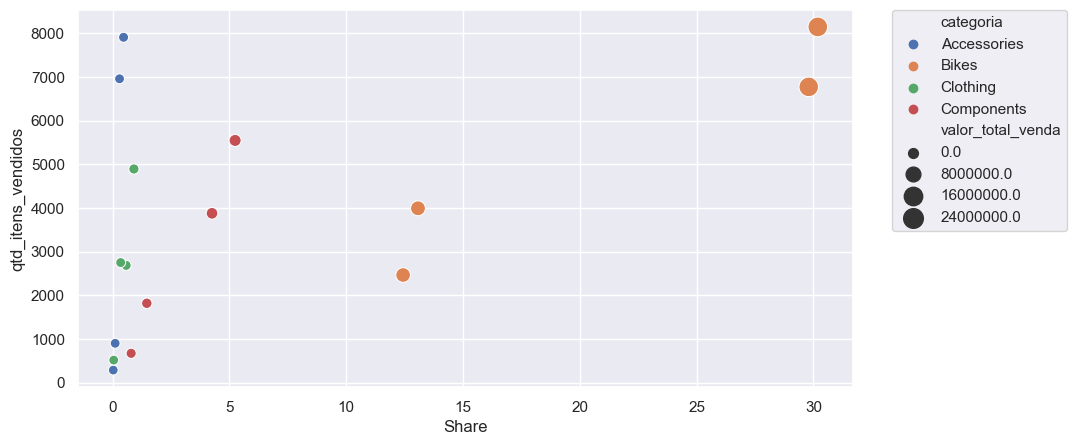

In [250]:
dados = df_ordersbyproduct.groupby(['categoria','ano']).agg('sum').reset_index()

f, axes = plt.subplots(1,figsize=(10,5))

sns.scatterplot(x="Share", y="qtd_itens_vendidos",size="valor_total_venda",
                sizes=(50, 200),hue="categoria", data=dados)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

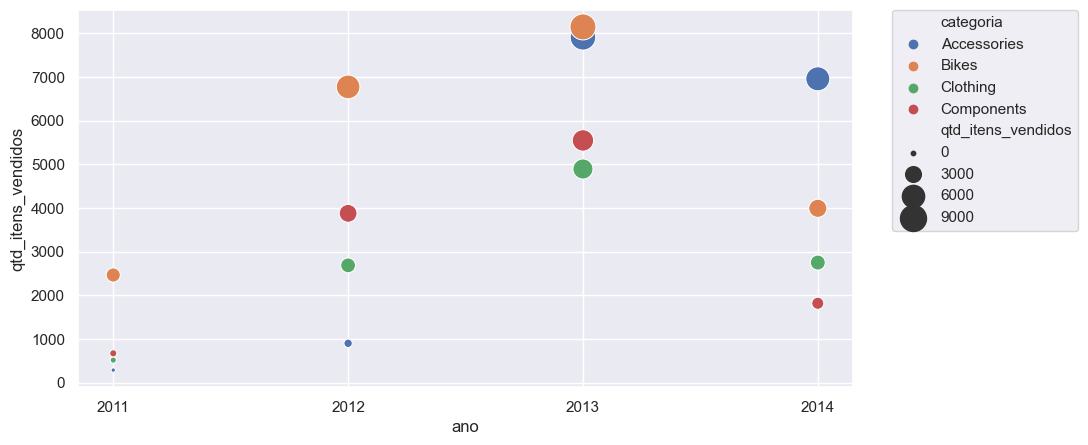

In [224]:
f, axes = plt.subplots(1,figsize=(10,5))

sns.scatterplot(x="ano", y="qtd_itens_vendidos",size="qtd_itens_vendidos",
                sizes=(10, 350),hue="categoria", data=dados)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

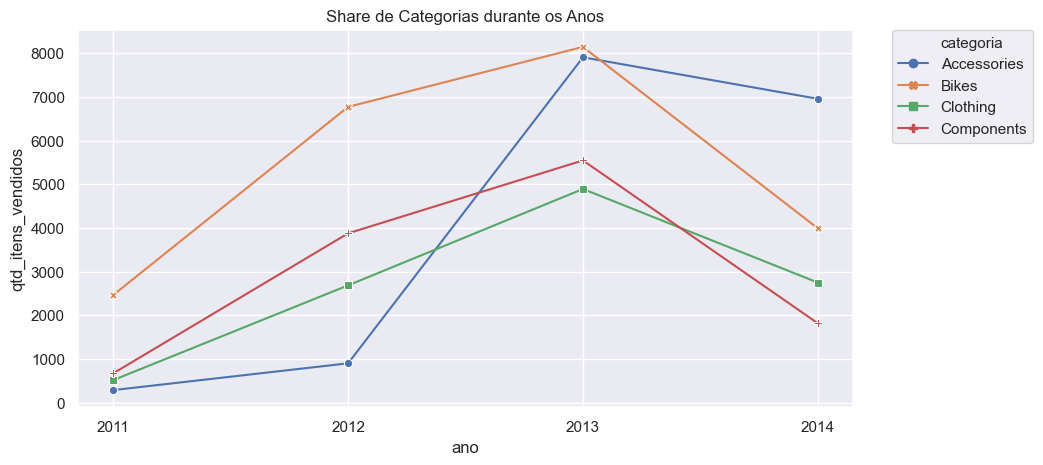

In [225]:
sns.set(style="darkgrid")

f, axes = plt.subplots(1,figsize=(10,5))

sns.lineplot(x="ano", y="qtd_itens_vendidos",hue="categoria",
             style="categoria",markers=True, dashes=False,data=dados)

plt.title("Share de Categorias durante os Anos")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [226]:
ano2011 = df_ordersbyproduct.loc[df_ordersbyproduct['ano'] == '2011']
ano2012 = df_ordersbyproduct.loc[df_ordersbyproduct['ano'] == '2012']
ano2013 = df_ordersbyproduct.loc[df_ordersbyproduct['ano'] == '2013']
ano2014 = df_ordersbyproduct.loc[df_ordersbyproduct['ano'] == '2014']

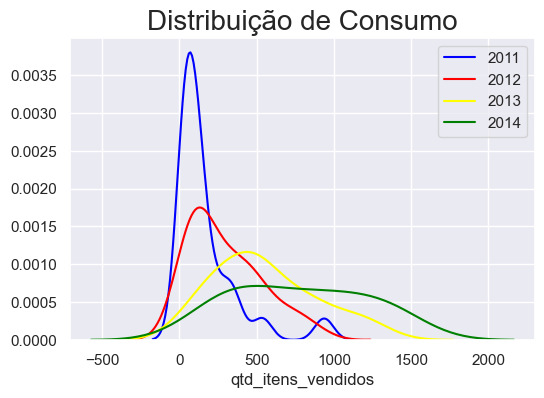

In [227]:


sns.distplot(ano2011['qtd_itens_vendidos'], color="blue", label="2011",hist=False)
sns.distplot(ano2012['qtd_itens_vendidos'], color="red", label="2012",hist=False)
sns.distplot(ano2013['qtd_itens_vendidos'], color="yellow", label="2013",hist=False)
sns.distplot(ano2014['qtd_itens_vendidos'], color="green", label="2014",hist=False)

#plt.legend()
plt.title("Distribuição de Consumo",fontsize=20)
plt.show()



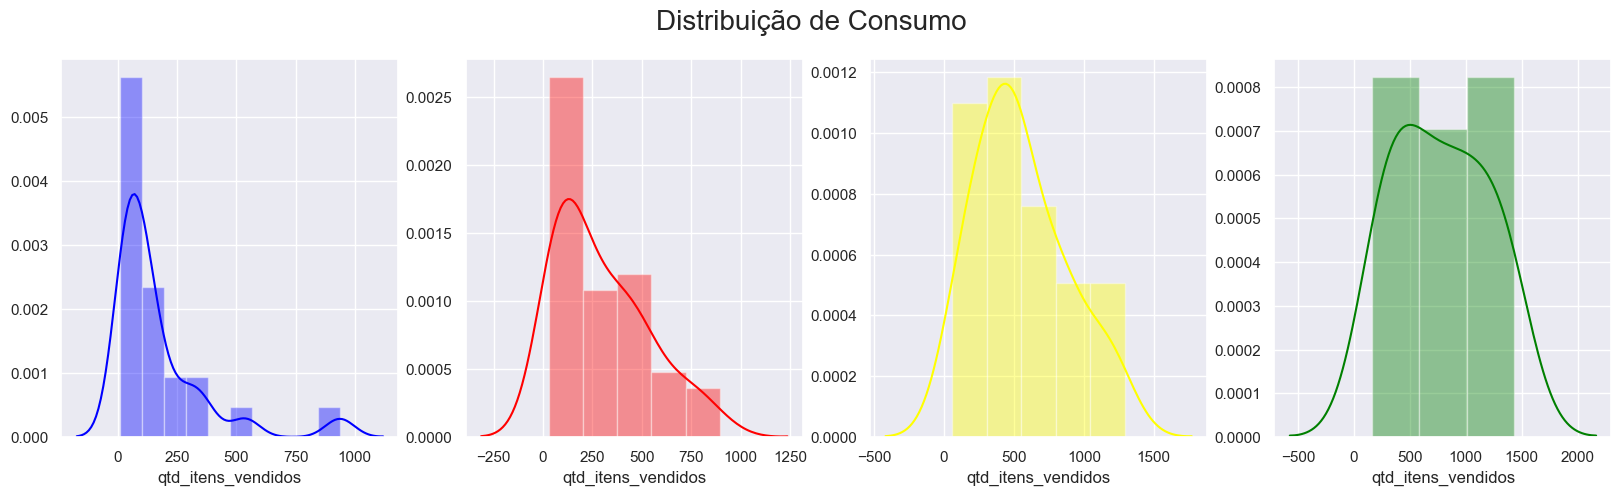

In [228]:
sns.set(color_codes=True)

f, axes = plt.subplots(1, 4, figsize=(20,5))

sns.distplot(ano2011['qtd_itens_vendidos'], color="blue", ax=axes[0])
sns.distplot(ano2012['qtd_itens_vendidos'], color="red", ax=axes[1])
sns.distplot(ano2013['qtd_itens_vendidos'], color="yellow", ax=axes[2])
sns.distplot(ano2014['qtd_itens_vendidos'] , color="green", ax=axes[3])

f.suptitle('Distribuição de Consumo',fontsize=20)

plt.show()

In [229]:
dados_mes_2014 = ano2014.groupby(['categoria','mes']).agg('sum').reset_index()
dados_mes_2013 = ano2013.groupby(['categoria','mes']).agg('sum').reset_index()
dados_mes_2012 = ano2012.groupby(['categoria','mes']).agg('sum').reset_index()
dados_mes_2011 = ano2011.groupby(['categoria','mes']).agg('sum').reset_index()

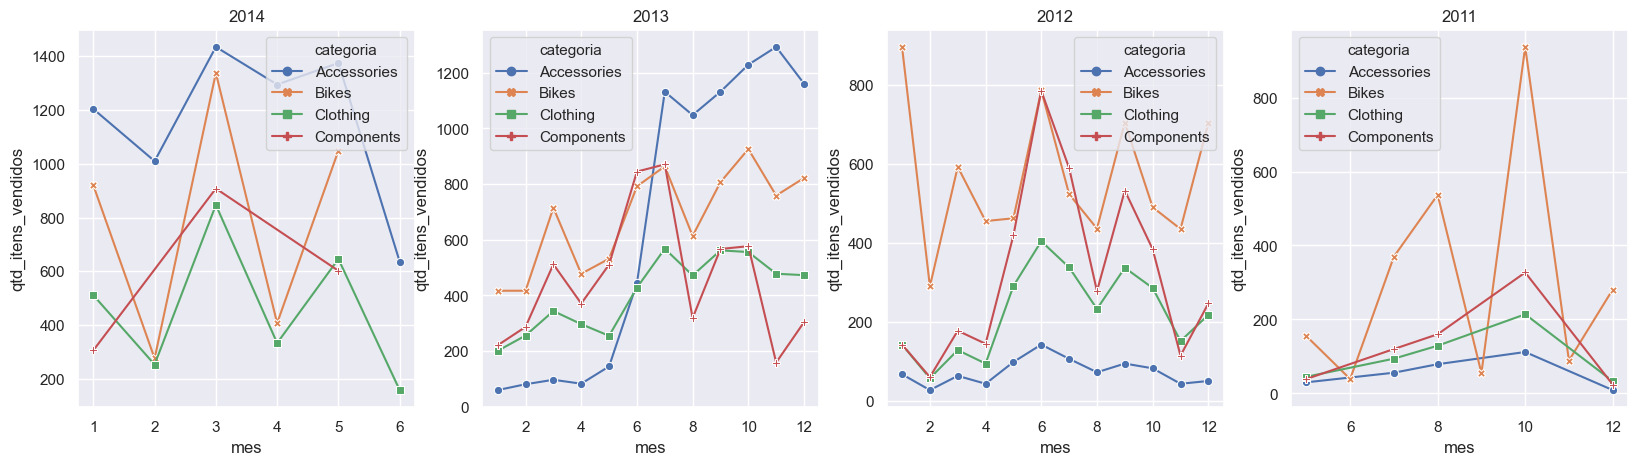

In [233]:

f, axes = plt.subplots(1, 4, figsize=(20,5))

sns.lineplot(x="mes", y="qtd_itens_vendidos",markers=True, dashes=False,
            style="categoria", hue="categoria",data=dados_mes_2014, ax=axes[0])
sns.lineplot(x="mes", y="qtd_itens_vendidos",markers=True, dashes=False,
            style="categoria", hue="categoria",data=dados_mes_2013, ax=axes[1])
sns.lineplot(x="mes", y="qtd_itens_vendidos",markers=True, dashes=False,
            style="categoria", hue="categoria",data=dados_mes_2012, ax=axes[2])
sns.lineplot(x="mes", y="qtd_itens_vendidos",markers=True, dashes=False,
            style="categoria", hue="categoria",data=dados_mes_2011, ax=axes[3])


axes[0].set_title('2014')
axes[1].set_title('2013')
axes[2].set_title('2012')
axes[3].set_title('2011')

plt.show()

In [247]:
dados

,categoria,ano,mes,valor_total_venda,qtd_itens_vendidos,Share
0,Accessories,2011,42,1.547564e+04,286,0.024445
1,Accessories,2012,78,6.719458e+04,899,0.106138
2,Accessories,2013,78,2.949943e+05,7905,0.465962
3,Accessories,2014,21,1.856788e+05,6955,0.293291
4,Bikes,2011,68,7.871269e+06,2463,12.433151
5,Bikes,2012,78,1.886660e+07,6770,29.800955
6,Bikes,2013,78,1.911232e+07,8143,30.189081
7,Bikes,2014,15,8.275259e+06,3990,13.071278
8,Clothing,2011,42,2.784357e+04,515,0.043981
9,Clothing,2012,78,3.639465e+05,2684,0.574876


In [243]:
pearsoncorr = df_ordersbyproduct.corr(method='pearson')
pearsoncorr

,mes,valor_total_venda,qtd_itens_vendidos,Share
mes,1.000000,0.003559,0.009140,0.003559
valor_total_venda,0.003559,1.000000,0.452652,1.000000
qtd_itens_vendidos,0.009140,0.452652,1.000000,0.452652
Share,0.003559,1.000000,0.452652,1.000000


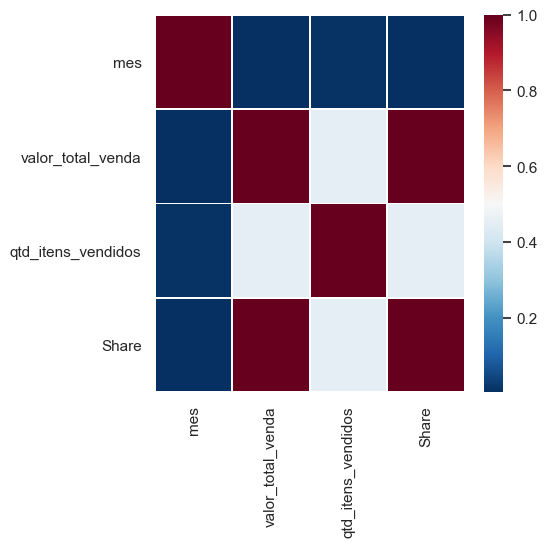

In [236]:
fig1, ax1 = plt.subplots(1,figsize=(5,5))
sns.heatmap(pearsoncorr,
            cmap='RdBu_r', 
            linewidths=.5)
plt.show()

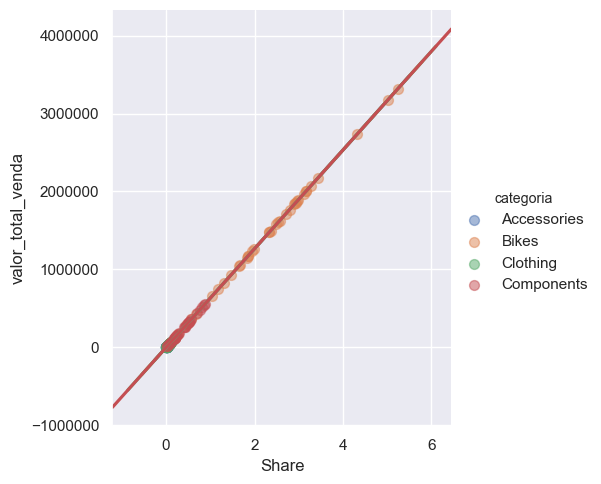

In [259]:
sns.lmplot(x="Share", y="valor_total_venda", hue="categoria",data=df_ordersbyproduct,
          scatter_kws={"s": 50, "alpha": 0.5})

plt.show()